In [117]:
from Rubik2.Rubik2 import *
from dataHelper import *
from collections import deque
import csv
import matplotlib.pyplot as plt
from collections import Counter
import random
import tensorflow as tf
import time

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
cube = Rubik2()
cube.show()
cube.rotateBottom()
cube.rotateLeft()
cube.rotateBack()
cube.show()
asstring = cube.getStateCompact()
newCube = Rubik2(asstring)
newCube.show()

bb
bb
ww rr yy oo
ww rr yy oo
gg
gg

yy
br
rg yo bb rw
bw rg yg oo
wg
wo

yy
br
rg yo bb rw
bw rg yg oo
wg
wo



In [13]:
def addNeighbors(current_states, visited_states):
    if(len(current_states) == 0): 
        return #empty queue
    
    (current_string, path_length) = current_states.popleft()
    
    for action in range(6):
        state = Rubik2(current_string)
        state.performMove(action)
        new_state_string = state.getStateCompact()
        
        if(new_state_string in visited_states): #state is already visited
            continue 
        current_states.append((new_state_string, path_length + 1))
        visited_states[new_state_string] = (path_length + 1, action)
        

In [33]:
visited[solved_state.getStateCompact()] = (0, -1)

In [19]:
visited = dict()
solved_state = Rubik2().getStateCompact()
current_states = deque()
current_states.append((solved_state, 0))
visited[solved_state] = (0, -1)

i = 0
while current_states:
    if(i % 10000 == 0) :
        print(i, len(current_states), len(visited))
        
    addNeighbors(current_states, visited)
    i += 1



0 1 0
10000 28280 38279
20000 54398 74397
30000 79329 109328
40000 102945 142944
50000 127112 177111
60000 151546 211545
70000 174678 244677
80000 198024 278023
90000 220195 310194
100000 242301 342300
110000 263381 373380
120000 284268 404267
130000 304292 434291
140000 324137 464136
150000 343813 493812
160000 362601 522600
170000 385888 555887
180000 408206 588205
190000 430185 620184
200000 451042 651041
210000 472058 682057
220000 491806 711805
230000 511727 741726
240000 531024 771023
250000 549766 799765
260000 568932 828931
270000 587631 857630
280000 605815 885814
290000 623165 913164
300000 640292 940291
310000 656799 966798
320000 673813 993812
330000 690309 1020308
340000 706588 1046587
350000 722031 1072030
360000 736652 1096651
370000 751521 1121520
380000 765608 1145607
390000 779859 1169858
400000 793769 1193768
410000 807193 1217192
420000 819929 1239928
430000 832842 1262841
440000 845338 1285337
450000 857502 1307501
460000 869172 1329171
470000 880580 1350579
480000

3550000 123861 3673860
3560000 113877 3673876
3570000 103883 3673882
3580000 93885 3673884
3590000 83938 3673937
3600000 74025 3674024
3610000 64063 3674062
3620000 54099 3674098
3630000 44121 3674120
3640000 34137 3674136
3650000 24153 3674152
3660000 14159 3674158
3670000 4161 3674160


In [34]:
with open("data1.csv", "w", newline='') as fp:
    w = csv.writer(fp)
    for key, (steps, move) in visited.items():
        w.writerow([key, move, steps])

In [2]:
with open("data1.csv") as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    data2 = dict((rows[0], (int(rows[1]), int(rows[2]))) for rows in reader)


In [36]:
len(data2)

3674160

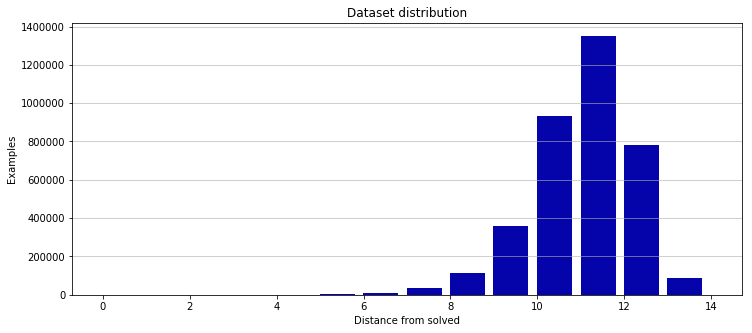

Counter({11: 1350852, 10: 930588, 12: 782536, 9: 360508, 8: 114149, 13: 90280, 7: 33058, 6: 8969, 5: 2256, 4: 534, 14: 276, 3: 120, 2: 27, 1: 6, 0: 1})


In [3]:
showDistribution(data2)


In [4]:
balancedData = balanceData(data2)

In [5]:
len(balancedData)

9818512

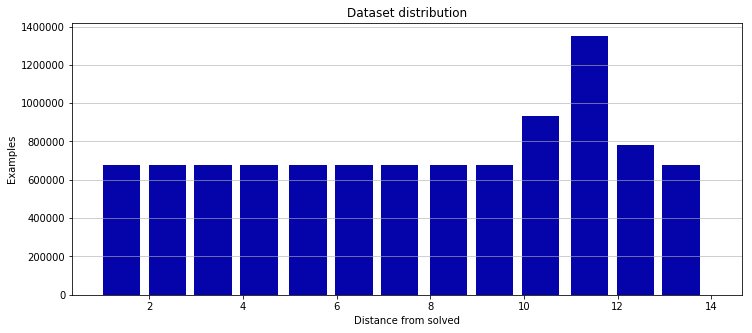

Counter({11: 1350852, 10: 930588, 12: 782536, 1: 675426, 2: 675426, 3: 675426, 4: 675426, 5: 675426, 6: 675426, 7: 675426, 8: 675426, 9: 675426, 13: 675426, 14: 276})


In [6]:
showDistributionList(balancedData)

In [7]:
#print(balancedData[0: 3])
random.shuffle(balancedData)
#print(balancedData[0: 3])

In [9]:
moveLabels, cubesAsVectors, _ = transformDataIntoExamples(balancedData)

In [10]:
num_moves = 6   # const

data_len = len(balancedData)
train_len = data_len
val_len = int(data_len * 0.01)

train_data = cubesAsVectors
train_labels = moveLabels
train_labels_one_hot = (np.arange(num_moves) == train_labels.reshape(-1, 1)).astype(np.float32)

val_data = cubesAsVectors[:val_len]
val_labels = moveLabels[:val_len]
val_labels_one_hot = (np.arange(num_moves) == val_labels.reshape(-1, 1)).astype(np.float32)

train_indices = range(train_len)

In [11]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [12]:
def generate_train_batch(batch_size):
    mask = np.asarray(random.sample(train_indices, batch_size))
    
    batch = train_data[mask]
    labels = train_labels_one_hot[mask]
    
    return batch, labels

In [150]:
batch_size = 128

hidden1 = 2048
hidden2 = 1024
hidden3 = 512

num_colors = 6   # const
num_sides = 6   # const
num_stickers = 21 # const # 3 sides with 3 stickers and 3 sides with 4 stickers
num_input_dimensions = num_stickers * num_colors # 126 - const

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, num_input_dimensions))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_moves))
    tf_valid_dataset = tf.constant(val_data)
    
    W1 = tf.Variable(tf.truncated_normal([num_input_dimensions, hidden1], stddev=0.1), name="W1")
    b1 = tf.Variable(tf.zeros([hidden1]), name="b1")
    
    W2 = tf.Variable(tf.truncated_normal([hidden1, hidden2], stddev=0.1), name="W2")
    b2 = tf.Variable(tf.zeros([hidden2]), name="b2")
    
    W3 = tf.Variable(tf.truncated_normal([hidden2, hidden3], stddev=0.1), name="W3")
    b3 = tf.Variable(tf.zeros([hidden3]), name="b3")
    
    W4 = tf.Variable(tf.truncated_normal([hidden3, num_moves], stddev=0.1), name="W4")
    b4 = tf.Variable(tf.zeros([num_moves]), name="b4")
    
    def model(data):
        layer1_raw = tf.matmul(data, W1) + b1
        layer1 = tf.nn.relu(layer1_raw)
        
        layer2_raw = tf.matmul(layer1, W2) + b2
        layer2 = tf.nn.relu(layer2_raw)
        
        layer3_raw = tf.matmul(layer2, W3) + b3
        layer3 = tf.nn.relu(layer3_raw)
        
        logits = tf.matmul(layer3, W4) + b4
        
        return logits
    
    def compute_loss(labels, logits):
        return tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))

    # Training computation.
    logits = model(tf_train_dataset)
    
    loss = compute_loss(tf_train_labels, logits)
    
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training and validation data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))


In [155]:
num_steps = 2000001 # 3001 #

start = time.time()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), val_labels_one_hot))
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_train_batch(batch_size)
        feed_dictionary = {tf_train_dataset : batch_data, tf_train_labels : batch_labels} 
        tempVal = session.run([optimizer, loss], feed_dict=feed_dictionary)
        l = tempVal[1]
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            
    print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), val_labels_one_hot))
    saver = tf.train.Saver()
    save_path = saver.save(session, "./models/model")
    print("Model saved in path: %s" % save_path)

end = time.time()
seconds = end - start
print("seconds ", seconds)
print("minutes ", seconds//60)


Validation accuracy: 18.1%
Initialized
Average loss at step 2000: 1.302542
Average loss at step 4000: 1.173354
Average loss at step 6000: 1.138110
Average loss at step 8000: 1.110272
Average loss at step 10000: 1.090744
Average loss at step 12000: 1.075896
Average loss at step 14000: 1.065093
Average loss at step 16000: 1.050598
Average loss at step 18000: 1.045570
Average loss at step 20000: 1.034380
Average loss at step 22000: 1.026370
Average loss at step 24000: 1.019291
Average loss at step 26000: 1.014642
Average loss at step 28000: 1.006135
Average loss at step 30000: 1.004191
Average loss at step 32000: 0.999642
Average loss at step 34000: 0.992518
Average loss at step 36000: 0.987855
Average loss at step 38000: 0.982152
Average loss at step 40000: 0.980181
Average loss at step 42000: 0.978646
Average loss at step 44000: 0.972558
Average loss at step 46000: 0.970183
Average loss at step 48000: 0.964541
Average loss at step 50000: 0.965616
Average loss at step 52000: 0.958193
Ave

Average loss at step 434000: 0.761553
Average loss at step 436000: 0.757594
Average loss at step 438000: 0.762740
Average loss at step 440000: 0.759268
Average loss at step 442000: 0.760181
Average loss at step 444000: 0.753873
Average loss at step 446000: 0.757221
Average loss at step 448000: 0.758498
Average loss at step 450000: 0.759284
Average loss at step 452000: 0.753731
Average loss at step 454000: 0.754568
Average loss at step 456000: 0.756347
Average loss at step 458000: 0.754664
Average loss at step 460000: 0.752232
Average loss at step 462000: 0.757098
Average loss at step 464000: 0.753096
Average loss at step 466000: 0.753564
Average loss at step 468000: 0.752342
Average loss at step 470000: 0.751159
Average loss at step 472000: 0.746238
Average loss at step 474000: 0.749721
Average loss at step 476000: 0.747664
Average loss at step 478000: 0.749576
Average loss at step 480000: 0.747718
Average loss at step 482000: 0.747442
Average loss at step 484000: 0.747950
Average loss

Average loss at step 866000: 0.668447
Average loss at step 868000: 0.663036
Average loss at step 870000: 0.668445
Average loss at step 872000: 0.670659
Average loss at step 874000: 0.665958
Average loss at step 876000: 0.667863
Average loss at step 878000: 0.665420
Average loss at step 880000: 0.665032
Average loss at step 882000: 0.666761
Average loss at step 884000: 0.666745
Average loss at step 886000: 0.665975
Average loss at step 888000: 0.661084
Average loss at step 890000: 0.667517
Average loss at step 892000: 0.665986
Average loss at step 894000: 0.661554
Average loss at step 896000: 0.665704
Average loss at step 898000: 0.666041
Average loss at step 900000: 0.664562
Average loss at step 902000: 0.660119
Average loss at step 904000: 0.661879
Average loss at step 906000: 0.661480
Average loss at step 908000: 0.659583
Average loss at step 910000: 0.660673
Average loss at step 912000: 0.656590
Average loss at step 914000: 0.658720
Average loss at step 916000: 0.663280
Average loss

Average loss at step 1290000: 0.611017
Average loss at step 1292000: 0.612055
Average loss at step 1294000: 0.608301
Average loss at step 1296000: 0.610407
Average loss at step 1298000: 0.609990
Average loss at step 1300000: 0.607151
Average loss at step 1302000: 0.607364
Average loss at step 1304000: 0.610947
Average loss at step 1306000: 0.607453
Average loss at step 1308000: 0.609217
Average loss at step 1310000: 0.608229
Average loss at step 1312000: 0.608581
Average loss at step 1314000: 0.607843
Average loss at step 1316000: 0.607318
Average loss at step 1318000: 0.605893
Average loss at step 1320000: 0.607051
Average loss at step 1322000: 0.608400
Average loss at step 1324000: 0.606001
Average loss at step 1326000: 0.606604
Average loss at step 1328000: 0.609204
Average loss at step 1330000: 0.606466
Average loss at step 1332000: 0.606786
Average loss at step 1334000: 0.607493
Average loss at step 1336000: 0.603157
Average loss at step 1338000: 0.603626
Average loss at step 1340

Average loss at step 1712000: 0.568911
Average loss at step 1714000: 0.567186
Average loss at step 1716000: 0.566784
Average loss at step 1718000: 0.566183
Average loss at step 1720000: 0.566542
Average loss at step 1722000: 0.566288
Average loss at step 1724000: 0.566696
Average loss at step 1726000: 0.567790
Average loss at step 1728000: 0.568059
Average loss at step 1730000: 0.564736
Average loss at step 1732000: 0.567455
Average loss at step 1734000: 0.565555
Average loss at step 1736000: 0.569313
Average loss at step 1738000: 0.567603
Average loss at step 1740000: 0.569599
Average loss at step 1742000: 0.570211
Average loss at step 1744000: 0.566529
Average loss at step 1746000: 0.562760
Average loss at step 1748000: 0.563628
Average loss at step 1750000: 0.567290
Average loss at step 1752000: 0.567181
Average loss at step 1754000: 0.566608
Average loss at step 1756000: 0.566368
Average loss at step 1758000: 0.563448
Average loss at step 1760000: 0.562838
Average loss at step 1762

In [172]:
batch_size2 = 1024

tf.reset_default_graph()

session2 = tf.Session()

new_saver = tf.train.import_meta_graph('./models/model.meta')
new_saver.restore(session2, tf.train.latest_checkpoint('./models/'))

print('Restoring data')

graph2 = tf.get_default_graph()

tf_train_dataset2 = tf.placeholder(tf.float32, shape=(batch_size2, num_input_dimensions))
tf_train_labels2 = tf.placeholder(tf.float32, shape=(batch_size2, num_moves))
tf_valid_dataset2 = tf.constant(val_data)

W1 = graph2.get_tensor_by_name("W1:0")
b1 = graph2.get_tensor_by_name("b1:0")

W2 = graph2.get_tensor_by_name("W2:0")
b2 = graph2.get_tensor_by_name("b2:0")

W3 = graph2.get_tensor_by_name("W3:0")
b3 = graph2.get_tensor_by_name("b3:0")

W4 = graph2.get_tensor_by_name("W4:0")
b4 = graph2.get_tensor_by_name("b4:0")

def model2(data):
    layer1_raw = tf.matmul(data, W1) + b1
    layer1 = tf.nn.relu(layer1_raw)

    layer2_raw = tf.matmul(layer1, W2) + b2
    layer2 = tf.nn.relu(layer2_raw)

    layer3_raw = tf.matmul(layer2, W3) + b3
    layer3 = tf.nn.relu(layer3_raw)

    logits = tf.matmul(layer3, W4) + b4

    return logits
    
def compute_loss2(labels, logits):
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))

# Training computation.
logits2 = model2(tf_train_dataset2)

loss2 = compute_loss2(tf_train_labels2, logits2)

optimizer2 = tf.train.GradientDescentOptimizer(0.01).minimize(loss2)

valid_prediction2 = tf.nn.softmax(model2(tf_valid_dataset2)) 

print('Validation accuracy: %.1f%%' % accuracy(valid_prediction2.eval(session=session2), val_labels_one_hot))
    
num_steps = 100001

start = time.time()

#tf.global_variables_initializer().run()
print('Initialized')

average_loss = 0
for step in range(num_steps):
    batch_data, batch_labels = generate_train_batch(batch_size2)
    feed_dictionary = {tf_train_dataset2 : batch_data, tf_train_labels2 : batch_labels} 
    tempVal = session2.run([optimizer2, loss2], feed_dict=feed_dictionary)
    l = tempVal[1]
    average_loss += l
    if step % 2000 == 0:
        if step > 0:
            average_loss = average_loss / 2000
        # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)

print('Validation accuracy: %.1f%%' % accuracy(valid_prediction2.eval(session=session2), val_labels_one_hot))
#saver3 = tf.train.Saver()
save_path = new_saver.save(session2, "./models2/model")
print("Model saved in path: %s" % save_path)

end = time.time()
seconds = end - start
print("seconds ", seconds)
print("minutes ", seconds//60)

INFO:tensorflow:Restoring parameters from ./models/model
Restoring data
Validation accuracy: 80.3%
Initialized
Average loss at step 2000: 0.531395
Average loss at step 4000: 0.520662
Average loss at step 6000: 0.516523
Average loss at step 8000: 0.511995
Average loss at step 10000: 0.508726
Average loss at step 12000: 0.506995
Average loss at step 14000: 0.504791
Average loss at step 16000: 0.504013
Average loss at step 18000: 0.500729
Average loss at step 20000: 0.499691
Average loss at step 22000: 0.497117
Average loss at step 24000: 0.496394
Average loss at step 26000: 0.496032
Average loss at step 28000: 0.495294
Average loss at step 30000: 0.493351
Average loss at step 32000: 0.492674
Average loss at step 34000: 0.491275
Average loss at step 36000: 0.490298
Average loss at step 38000: 0.489996
Average loss at step 40000: 0.488864
Average loss at step 42000: 0.488384
Average loss at step 44000: 0.488605
Average loss at step 46000: 0.486936
Average loss at step 48000: 0.487063
Avera

In [55]:
unbalancedData = transformWithoutBalansing(data2)
random.shuffle(balancedData) #unbalancedData
moveLabelsUnique, cubesAsVectorsUnique, states = transformDataIntoExamples(balancedData)#unbalancedData



In [56]:
data_len = len(balancedData)#unbalancedData
val_len = int(data_len * 0.01)

val_data = cubesAsVectorsUnique[:val_len]
val_states = states[:val_len]

In [57]:
tf.reset_default_graph()

session3 = tf.Session()

new_saver = tf.train.import_meta_graph('./models2/model.meta')
new_saver.restore(session3, tf.train.latest_checkpoint('./models2/'))

print('Restoring data')

graph3 = tf.get_default_graph()

W1 = graph3.get_tensor_by_name("W1:0")
b1 = graph3.get_tensor_by_name("b1:0")

W2 = graph3.get_tensor_by_name("W2:0")
b2 = graph3.get_tensor_by_name("b2:0")

W3 = graph3.get_tensor_by_name("W3:0")
b3 = graph3.get_tensor_by_name("b3:0")

W4 = graph3.get_tensor_by_name("W4:0")
b4 = graph3.get_tensor_by_name("b4:0")

def model3(data):
    layer1_raw = tf.matmul(data, W1) + b1
    layer1 = tf.nn.relu(layer1_raw)

    layer2_raw = tf.matmul(layer1, W2) + b2
    layer2 = tf.nn.relu(layer2_raw)

    layer3_raw = tf.matmul(layer2, W3) + b3
    layer3 = tf.nn.relu(layer3_raw)

    logits = tf.matmul(layer3, W4) + b4

    return logits
    

INFO:tensorflow:Restoring parameters from ./models2/model
Restoring data


In [119]:
current_test_data = val_data
current_test_data_as_strings = val_states

print(val_len)
max_moves = 40

results = []

start = time.time()

for step in range(max_moves):
    results.append(current_test_data)
    tf_test_iteration = tf.constant(current_test_data)
    #print(current_test_data[0:2])
    iteration_logits = tf.nn.softmax(model3(tf_test_iteration)).eval(session=session3)
    iteration_moves = np.argmax(iteration_logits, axis=1)
    
    tempArr = list(map(performCubeAntiMovement, current_test_data_as_strings, iteration_moves))
    mapped_states_vector = np.asarray(list([ f for (f, _) in tempArr]))
    mapped_states_string = [ s for (_, s) in tempArr]
    #new_states = np.asarray(list(mappedStates))
    
    current_test_data = mapped_states_vector
    current_test_data_as_strings = mapped_states_string
    
    print("Step done: ", step)

end = time.time()
seconds = end - start
print("seconds ", seconds)
print("minutes ", seconds//60)


98185
Step done:  0
Step done:  1
Step done:  2
Step done:  3
Step done:  4
Step done:  5
Step done:  6
Step done:  7
Step done:  8
Step done:  9
Step done:  10
Step done:  11
Step done:  12
Step done:  13
Step done:  14
Step done:  15
Step done:  16
Step done:  17
Step done:  18
Step done:  19
Step done:  20
Step done:  21
Step done:  22
Step done:  23
Step done:  24
Step done:  25
Step done:  26
Step done:  27
Step done:  28
Step done:  29
Step done:  30
Step done:  31
Step done:  32
Step done:  33
Step done:  34
Step done:  35
Step done:  36
Step done:  37
Step done:  38
Step done:  39
seconds  1753.1131119728088
minutes  29.0


40

In [121]:
test_length_final = val_len
solved_states = 0
print("val_len", test_length_final)
solved_state = convertStringToVector(Rubik2().getStateCompact())
#print(solved_state)
almost_solved = convertStringToVector(Rubik2().performMove(5).getStateCompact())
results[2][2] = almost_solved

for test in range(test_length_final):
    #if test % 100 == 0: print("test ", test)
    
    for move in range(max_moves):
        state = results[move][test]
        if(np.array_equal(state,solved_state)):
            #print("Solved: Test, move:", test, move)
            solved_states += 1
            break
            
print("solved %: ", solved_states / test_length_final * 100)

val_len 98185
solved %:  88.61027651881652


qwewrtryuioqwertyuiqwgertyuiqwertyuiiuytrew


In [113]:
mappedPath = [ data2[convertVectorToString(step[11])]  for step in results]
print(mappedPath)
mappedPath = [ convertVectorToString(step[11])  for step in results]
print(mappedPath)

[(2, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2), (3, 1), (2, 2)]
['rrwwyyrrooyywwoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowwwwrrrryyyyoobbbbgggg', 'yywwoorrwwyyrroobbbbgggg', 'oowww

In [100]:
for i in range(100):
    mappedPath = [ data2[convertVectorToString(step[i])][1]  for step in results]
    print(mappedPath)

[2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3]
[4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5]
[11, 12, 1, 12, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10]
[5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6]
[10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9]
[10, 11, 10, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11]
[7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8]
[9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 1

[10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11]
[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
[12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11]
[13, 12, 11, 12, 11, 12, 13, 12, 11, 10, 9, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10]
[12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11, 12, 11]
[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
[2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 